In [17]:
import pandas as pd
import seaborn as sns
import geopandas as geo
import pymongo
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 80)
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import KMeans,DBSCAN,OPTICS,Birch
import timeit


In [3]:
client = MongoClient()
client = MongoClient('localhost', 27017)

In [4]:
db = client.AISdata
nari_dynamic=db.nari_dynamic

# Fishing vessels

In [19]:
#Find distinct fishing vessels and count their fishing activity instances

query = ([
    { '$match':{'navigationalstatus':{'$eq':7}}},
    { '$group': {'_id':'$sourcemmsi', 
                 'num_appearances':{'$sum':1}}},
    { '$sort':{'num_appearances':-1}}
    ])

document = nari_dynamic.aggregate(query)

results=[]
for i in document:
    results.append(i)
    
    
res=pd.DataFrame(results).copy()
res['_id']=res['_id'].astype(str)

In [21]:
fishing_vessels=list(res['_id'].astype(int))
print('There are',len(fishing_vessels),'vessels that were fishing')

There are 208 vessels that were fishing


In [9]:
res.describe()

,num_appearances
count,208.0000
mean,8071.0577
std,26218.5440
min,1.0000
25%,33.0000
50%,453.5000
75%,2735.7500
max,232591.0000


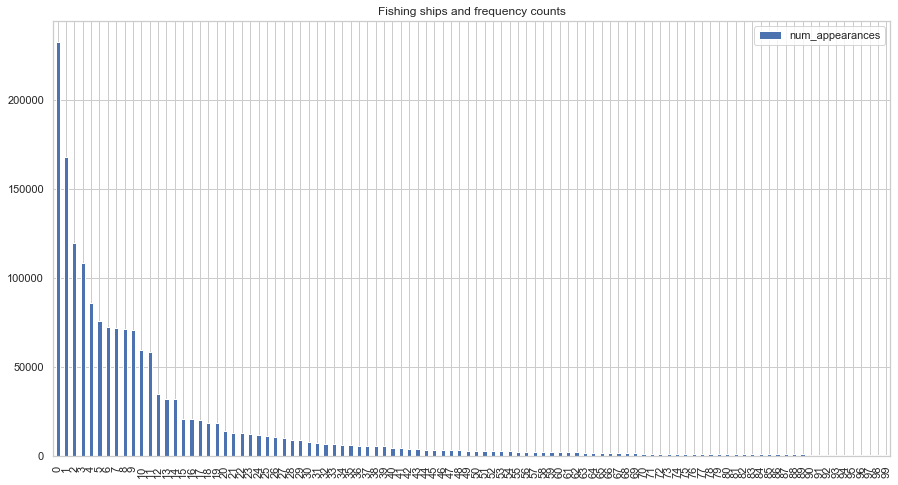

In [8]:
res[:100].plot(kind='bar',figsize=(15,8),title='Fishing ships and frequency counts')


In [112]:
mmsi=res['_id'].apply( lambda x : ''.join(list(x)[0:3]) )
print('There are vessels from',len(mmsi.unique()),'country codes that were fishing')
print('Country codes: ',mmsi.unique())

There are vessels from 11 country codes that were fishing
Country codes:  ['227' '228' '226' '224' '219' '232' '235' '244' '218' '225' '250']


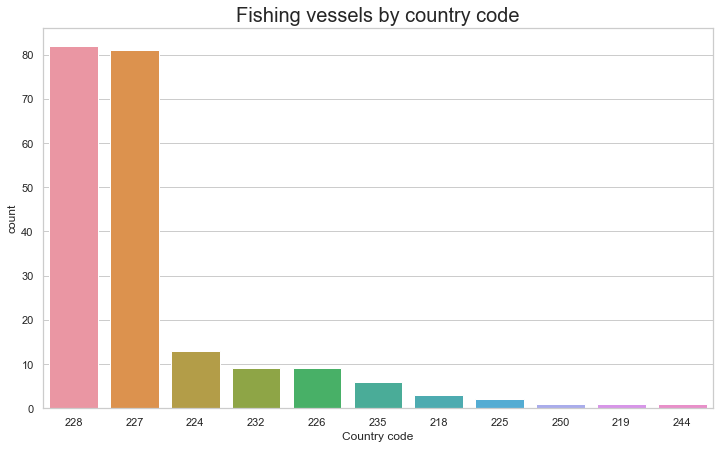

In [47]:
plt.figure(figsize=(12,7))
plt.title('Fishing vessels by country code',fontsize=20)
sns.countplot(mmsi,order = mmsi.value_counts().index)
plt.xlabel('Country code')
plt.show()

In [16]:
fishing_areas= geo.read_file("../data/[P1] AIS status, Codes and Types/MMSI Country Codes.csv")
print(fishing_areas.head())

    Name  maxLat  maxLong  minLat  minLong   cat  value  \
0  BREST    51.0      0.0    45.0    -10.0  3203      1   
1  BREST    51.0      0.0    45.0    -10.0  3208      1   
2  BREST    51.0      0.0    45.0    -10.0  3179      2   
3  BREST    51.0      0.0    45.0    -10.0  3209      2   
4  BREST    51.0      0.0    45.0    -10.0  3212      1   

                                            geometry  
0  POLYGON ((-3.051955070012085 49.07314176742069...  
1  POLYGON ((-3.84896124203464 49.06514169958743,...  
2  POLYGON ((-2.351949649164169 49.05114158087922...  
3  POLYGON ((-7.245987548635167 49.04014148760848...  
4  POLYGON ((-8.143994502808635 49.03514144521269...  


In [24]:
fishing_vessels[-164:-100:1]

[228843000,
 228157000,
 227310150,
 228874000,
 224113270,
 227336000,
 228126000,
 228066700,
 227317000,
 227472000,
 228172000,
 227127900,
 228374000,
 227310000,
 227483000,
 227375000,
 228332000,
 227827000,
 227143900,
 228048600,
 224792000,
 228033600,
 228107800,
 228301900,
 227308000,
 227584000,
 226179000,
 227977000,
 227411000,
 224384000,
 228130000,
 227579000,
 227595000,
 228888000,
 227855000,
 227563000,
 227877000,
 227309000,
 227915000,
 228282000,
 227532000,
 228236600,
 228209700,
 224130870,
 224052970,
 228070700,
 228259000,
 227866000,
 228258000,
 228033800,
 228252000,
 228264000,
 228216600,
 228383000,
 228120000,
 227426000,
 227843000,
 228236000,
 228367000,
 224227000,
 219017843,
 228281000,
 228385000,
 228042600]

# Trajectory clustering of fishing vessels

In [59]:
#Get all coordinates from the fishing vessels

query = ([
    { '$match':{'sourcemmsi':{'$in':fishing_vessels[-164:-10:1]}}},
    { '$group': {'_id':'$sourcemmsi', 
                 'locations':{'$push':'$location.coordinates'}}},
    { '$sort':{'t':-1}}
    ])

document2 = nari_dynamic.aggregate(query,allowDiskUse=True)

results2=[]
for i in document2:
    results2.append(i)
    
    
res2=pd.DataFrame(results2)
print(res2)
res2['_id']=res2['_id'].astype(str)

           _id                                          locations
0    226150000  [[-2.8469417, 46.808846], [-2.8375932999999995...
1    228120000  [[-2.610005, 45.885033], [-2.6056633, 45.88513...
2    227303000  [[-5.3681116, 48.111694], [-5.3650199999999995...
3    228240000  [[-4.841038, 47.854034000000006], [-4.81325, 4...
4    228203800  [[-5.135842, 48.717915000000005], [-5.13125, 4...
..         ...                                                ...
149  228236000  [[-5.0786614000000005, 47.633907], [-5.0735765...
150  228021600  [[-4.9238214000000005, 48.291733], [-4.918665,...
151  228106800  [[-4.6752234, 47.962368], [-4.676148400000001,...
152  226004000  [[-2.0297666000000003, 46.298626], [-1.923525,...
153  232005800  [[-5.9387784, 49.2931], [-5.9356465, 49.29647]...

[154 rows x 2 columns]


In [61]:
res2['locations']=res2['locations'].apply(lambda x: np.array(x))

In [78]:
all_coords = []
for sublist in res2.locations:
    for item in sublist:
        all_coords.append([item[0],item[1]])
        
all_coords = pd.DataFrame.from_records(all_coords,columns=['lon','lat'])        

In [90]:
from shapely.geometry import Point

crs = {'init': 'epsg:4326'}
geometry=[Point(xy) for xy in zip(all_coords.lon,all_coords.lat)]
fishing_boats=geo.GeoDataFrame(all_coords,crs=crs,geometry=geometry)
fishing_boats.head()

,lon,lat,geometry
0,-5.9226,48.2496,POINT (-5.9225984 48.249645)
1,-5.9226,48.2495,POINT (-5.9225636 48.24955)
2,-5.9225,48.2495,POINT (-5.922488 48.249474)
3,-5.9152,48.2409,POINT (-5.915171599999999 48.24085)
4,-5.9150,48.2407,POINT (-5.9149733 48.240726)


In [80]:
#Make a heatmap of fishing activity

import folium
from folium.plugins import HeatMap

fishing_map=folium.Map([48.370834, -4.512665], zoom_start=10)
folium.Marker([48.370834, -4.512665], popup='<i>Brest, France</i>',icon=folium.Icon(color='green', icon='home')).add_to(fishing_map)
HeatMap(data=all_coords, radius=5, max_zoom=13).add_to(fishing_map)
fishing_map.save( 'Heatmap_Fishing.html')


# Get monthly stats for fishing vessels

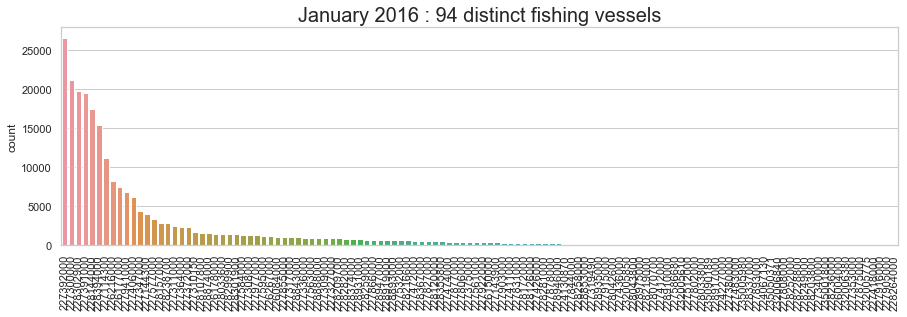

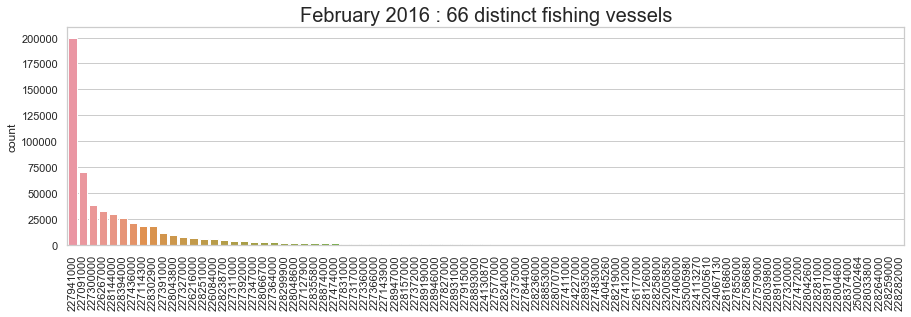

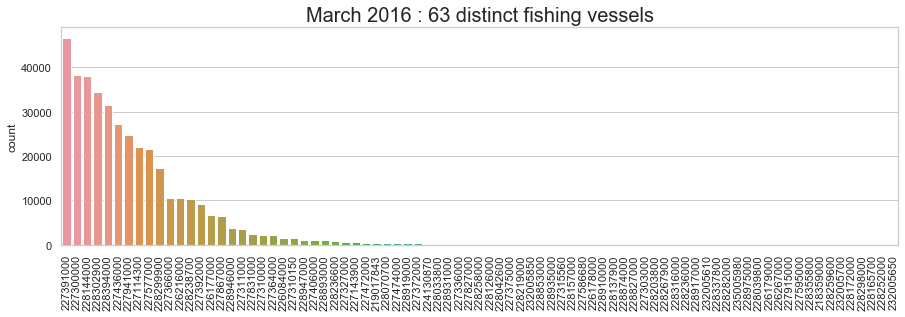

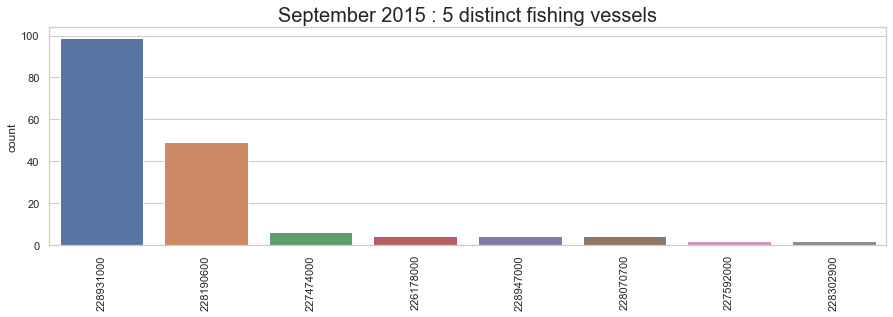

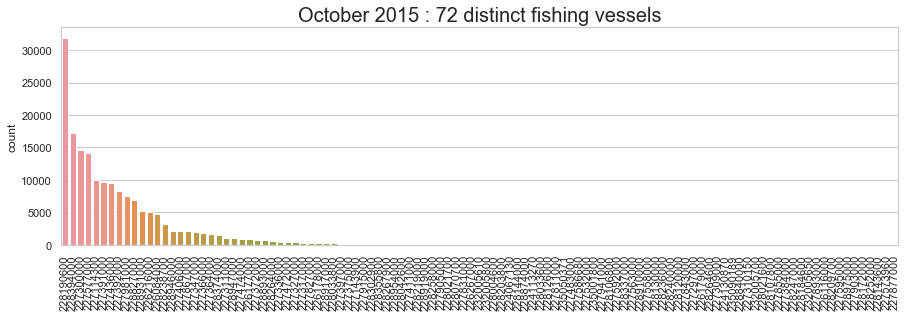

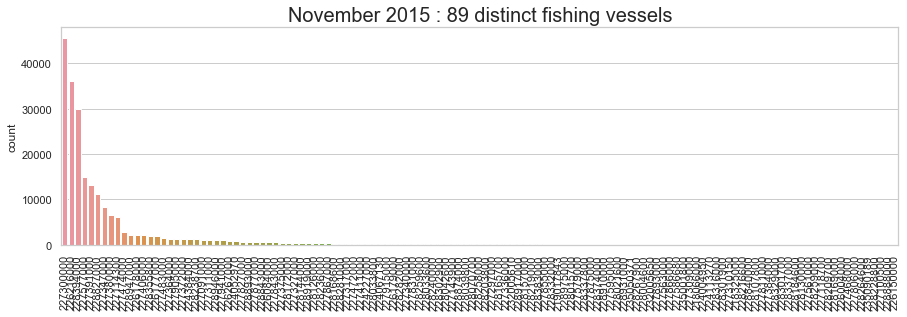

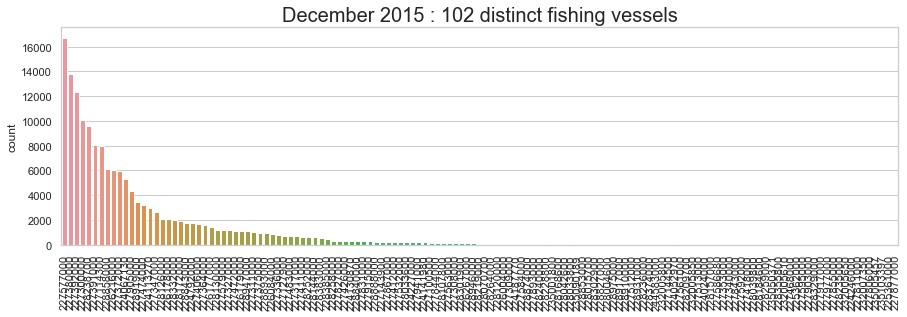

In [58]:
#Get all coordinates from the fishing vessels,group by months and  count

query = ([
    { '$match':{'navigationalstatus':{'$eq':7}}
    },
    { '$group': {'_id':{'month':{'$month':'$t'}},
                 'count':{'$sum':1},
                 'sourcemmsi':{'$push':'$sourcemmsi'}}
    },             
    { '$sort':{'_id':1}}
    ])

document = nari_dynamic.aggregate(query,allowDiskUse=True)

results=[]
for i in document:
    results.append(i)
    
res_monthly=pd.DataFrame(results)

months={
        1:'January 2016',
        2:'February 2016',
        3:'March 2016',
        9:'September 2015',
        10:'October 2015',
        11:'November 2015',
        12:'December 2015',
}
i=0

for month in res_monthly['_id']:
    
    montly_counts=pd.Series(res_monthly.sourcemmsi[i]).value_counts()

    plt.figure(figsize=(15,4))
    plt.title(months[month['month']]+' : '+str(len(np.unique(montly_counts)))+' distinct fishing vessels',fontsize=20)
    plot=sns.countplot(res_monthly.sourcemmsi[i],order=montly_counts.index)
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
    plt.show()
    i+=1

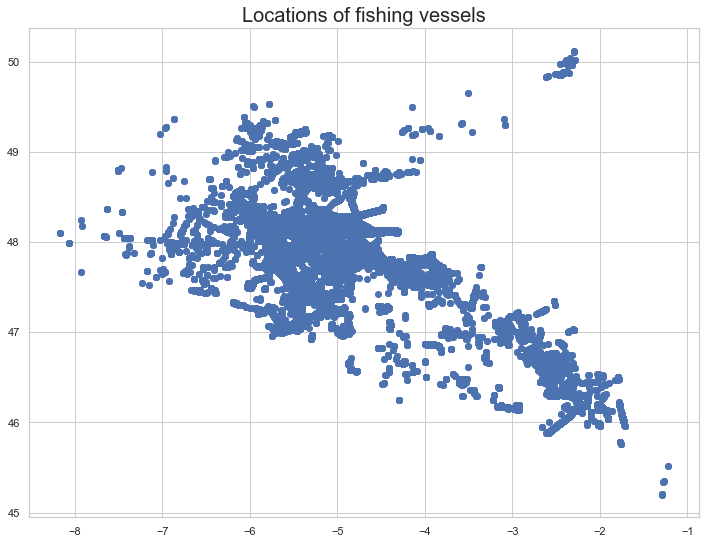

In [108]:

plt.figure(figsize=(12,9))
plt.title('Locations of fishing vessels',fontsize=20)
plt.scatter(fishing_boats.lon,fishing_boats.lat)
plt.show()

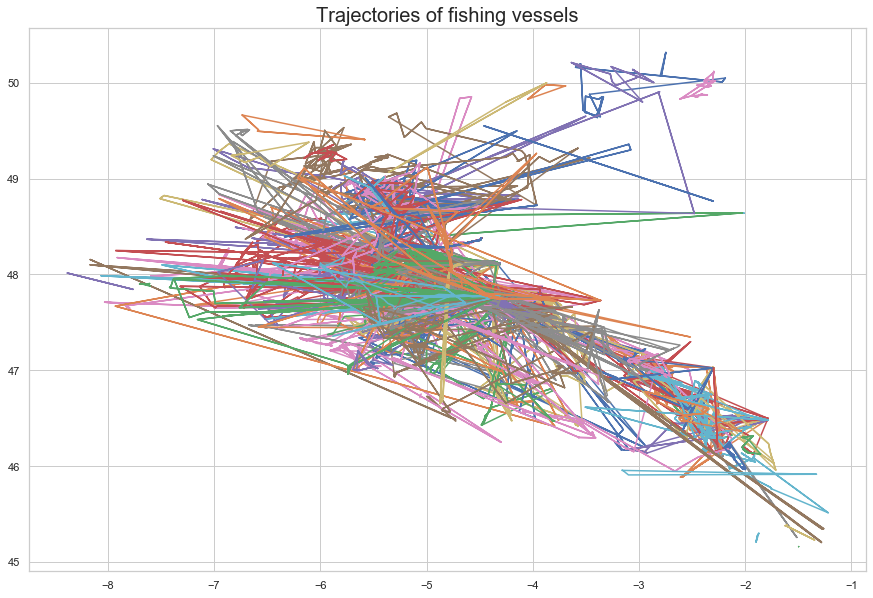

In [62]:
plt.figure(figsize=(15,10))
plt.title('Trajectories of fishing vessels',fontsize=20)
for trajectory in res2.locations:
    plt.plot(trajectory[:, 0], trajectory[:, 1])

In [63]:
#Creating hausdorff distance matrix

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(res2.locations)
D = np.zeros((traj_count, traj_count))


for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(res2.locations[i], res2.locations[j])
        D[i, j] = distance
        D[j, i] = distance

In [64]:

#Function for plottting clustered trajectories

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(trajs, clusters):

    cluster_count = np.max(clusters) + 1
    
    for traj, cluster in zip(trajs, clusters):
        
        if cluster == -1:
            plt.plot(traj[:, 0], traj[:, 1], c ='k', linestyle='dashed')
        
        else: 
            plt.plot(traj[:, 0], traj[:, 1], c = colors[cluster % len(colors)])
    plt.show()

In [12]:
from sklearn.cluster import KMeans

def elbow_method(data,max_clusters=10):
    inertias = []
    for k in range(2, max_clusters):
        kmeans = KMeans(n_clusters=k,random_state=7,n_jobs=-1)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    fig = plt.figure(figsize=(15, 8))
    plt.plot(range(2, max_clusters), inertias, 'bx-')
    plt.grid(True)
    plt.title('Elbow curve')

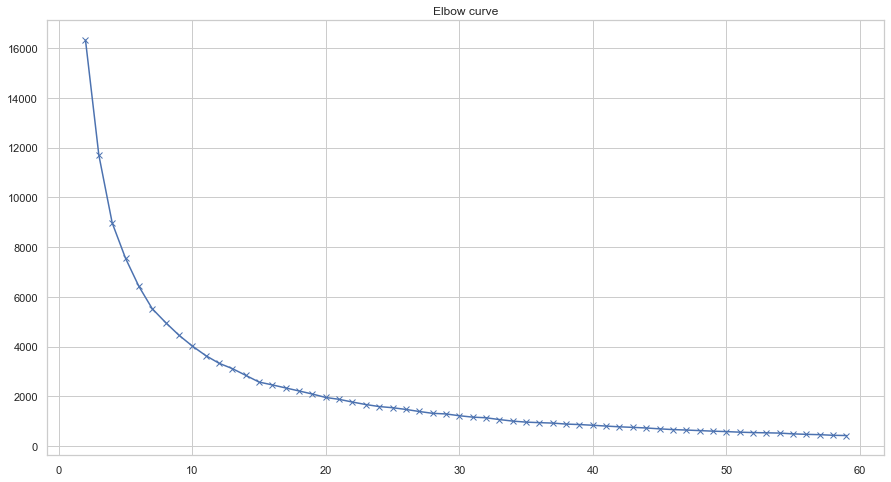

In [113]:
elbow_method(D,60)

Nof clusters: 7


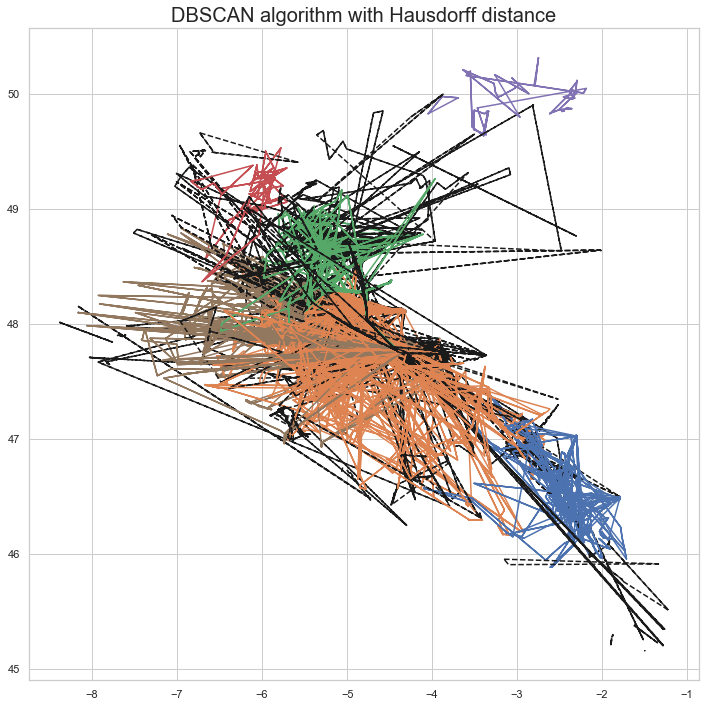

In [94]:
dbscan = DBSCAN(eps=4, min_samples=4,n_jobs=-1)
clusters = dbscan.fit_predict(D)
print('Nof clusters:',len(np.unique(clusters)))
plt.figure(figsize=(12,12))
plt.title('DBSCAN algorithm with Hausdorff distance',fontsize=20)
plot_cluster(res2.locations, clusters)


Nof clusters: 10


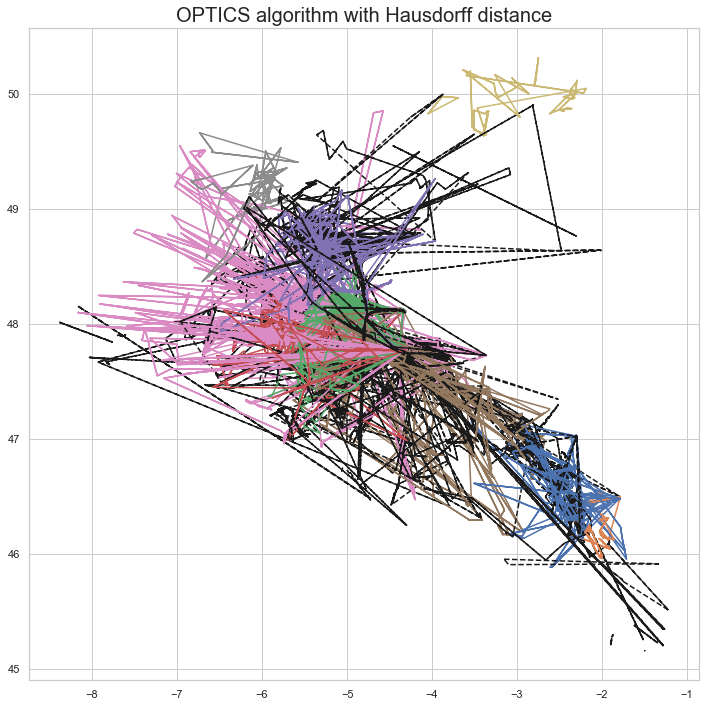

In [97]:
optics = OPTICS(eps=5, min_samples=6,leaf_size=30,n_jobs=-1)
clusters = optics.fit_predict(D)
print('Nof clusters:',len(np.unique(clusters)))
plt.figure(figsize=(12,12))
plt.title('OPTICS algorithm with Hausdorff distance',fontsize=20)
plot_cluster(res2.locations, clusters)


Nof clusters: 7


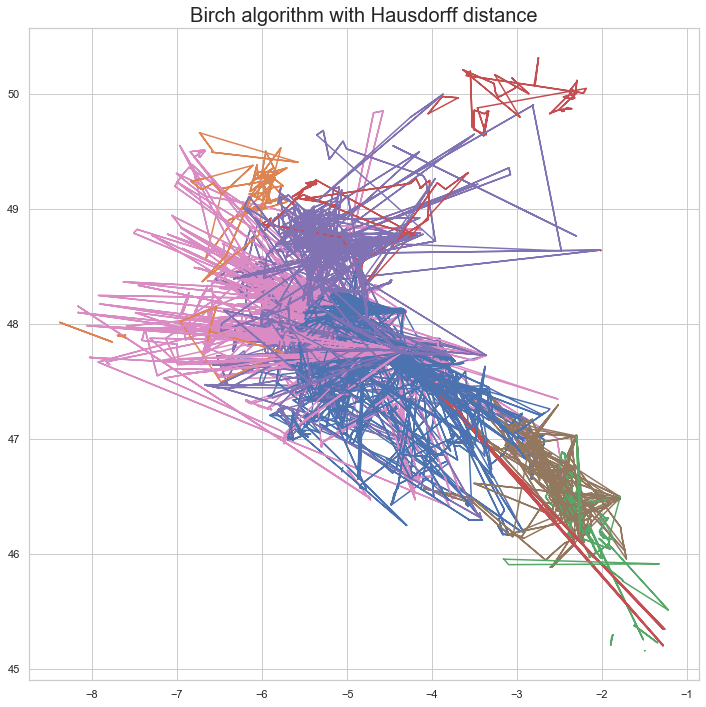

In [99]:
brc = Birch(n_clusters=7)
clusters = brc.fit_predict(D)
print('Nof clusters:',len(np.unique(clusters)))
plt.figure(figsize=(12,12))
plt.title('Birch algorithm with Hausdorff distance',fontsize=20)
plot_cluster(res2.locations, clusters)


# Clustering fishing spots

In [22]:
#Get all coordinates from the fishing vessels

query = ([
    { '$match':{'navigationalstatus':{'$eq':7},
                'sourcemmsi':{'$in':fishing_vessels[-164:-10:1]}}},
    { '$group': {'_id':'$sourcemmsi', 
                 'locations':{'$push':'$location.coordinates'}}},
    ])

document = nari_dynamic.aggregate(query,allowDiskUse=True)

results=[]
for i in document:
    results.append(i)
    
    
res3=pd.DataFrame(results)
print(res3)
res3['_id']=res3['_id'].astype(str)

           _id                                          locations
0    228165700  [[-5.48313, 48.052868], [-5.4478016, 48.180225...
1    227917000  [[-3.9261317000000004, 46.809765000000006], [-...
2    228259600  [[-5.413125, 48.310047], [-5.413128400000001, ...
3    232005610  [[-5.9764485, 49.1806], [-5.97653, 49.180412],...
4    244583000  [[-6.612483500000001, 47.937927], [-5.76842359...
..         ...                                                ...
149  228015700  [[-5.7436132, 48.27173], [-5.725103400000001, ...
150  227866000  [[-2.7333684, 46.641064], [-2.7425516, 46.6557...
151  228329000  [[-4.944442, 48.51279], [-5.081343, 48.40933],...
152  227127900  [[-4.671975, 47.960190000000004], [-4.6755533,...
153  235050371  [[-3.4663217000000004, 49.88029], [-3.36335329...

[154 rows x 2 columns]


In [23]:
fishing_coords = []
for sublist in res3.locations:
    for item in sublist:
        fishing_coords.append([item[0],item[1]])
        
fishing_coords = pd.DataFrame.from_records(fishing_coords,columns=['lon','lat'])    

In [24]:
print(len(fishing_coords))

98619


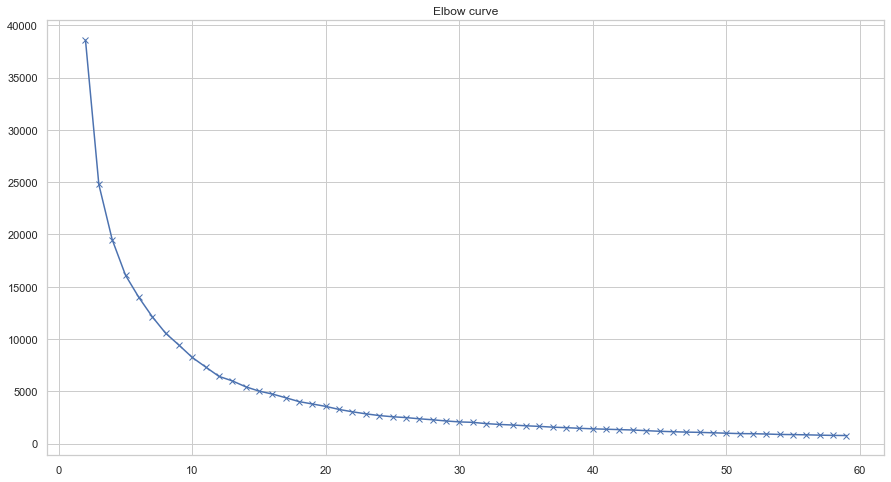

In [114]:
elbow_method(fishing_coords,60)

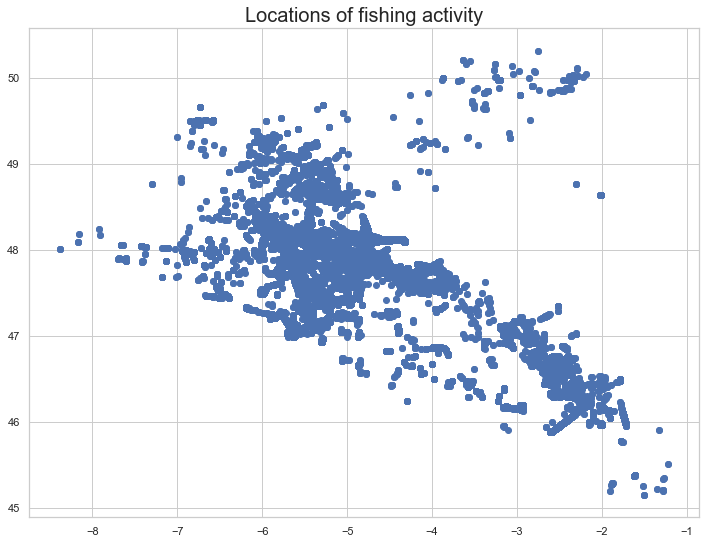

In [9]:
plt.figure(figsize=(12,9))
plt.title('Locations of fishing activity',fontsize=20)
plt.scatter(fishing_coords.lon,fishing_coords.lat)
plt.show()

## Using KMeans

Nof clusters: 7


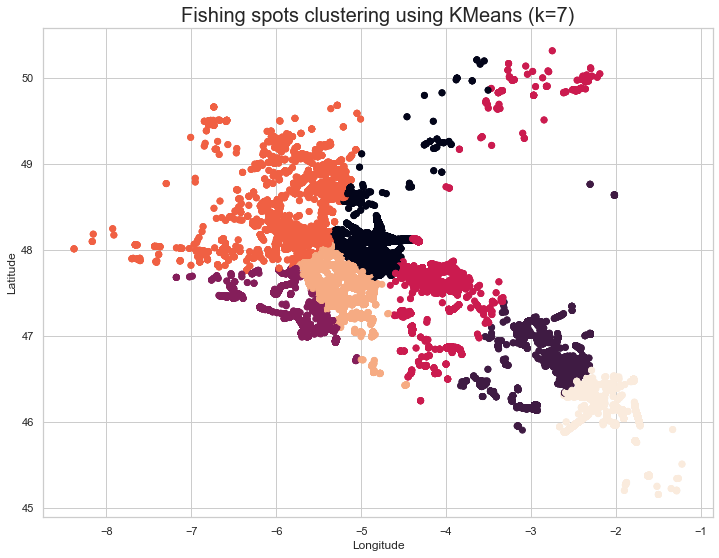

In [49]:
kmeans = KMeans(7,n_jobs=-1)
clusters = kmeans.fit_predict(fishing_coords)
print('Nof clusters:',len(np.unique(clusters)))

clusterd_fishing_coords=fishing_coords.copy()
clusterd_fishing_coords['clusters']=clusters

fig, ax = plt.subplots(figsize=[12, 9])
plt.scatter(fishing_coords.lon,fishing_coords.lat,c=clusters)
plt.title('Fishing spots clustering using KMeans (k=7)',fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

Nof clusters: 9


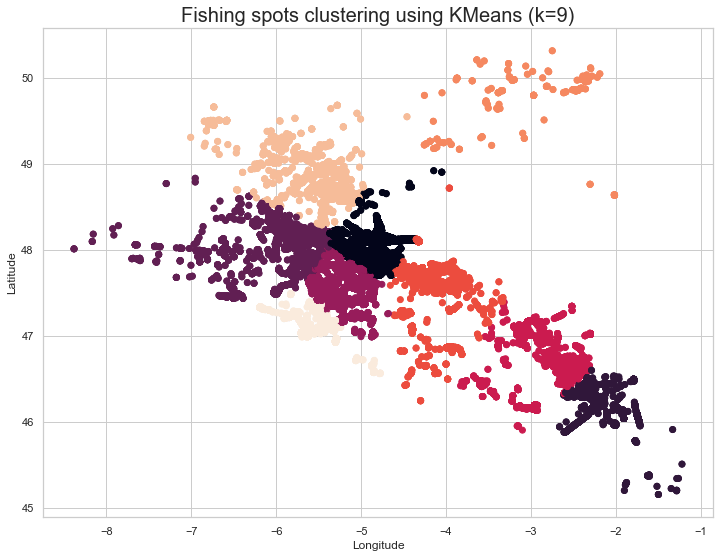

In [15]:
kmeans = KMeans(9,n_jobs=-1)
clusters = kmeans.fit_predict(fishing_coords)
print('Nof clusters:',len(np.unique(clusters)))

clusterd_fishing_coords=fishing_coords.copy()
clusterd_fishing_coords['clusters']=clusters

fig, ax = plt.subplots(figsize=[12, 9])
plt.scatter(fishing_coords.lon,fishing_coords.lat,c=clusters)
plt.title('Fishing spots clustering using KMeans (k=9)',fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

Nof clusters: 7


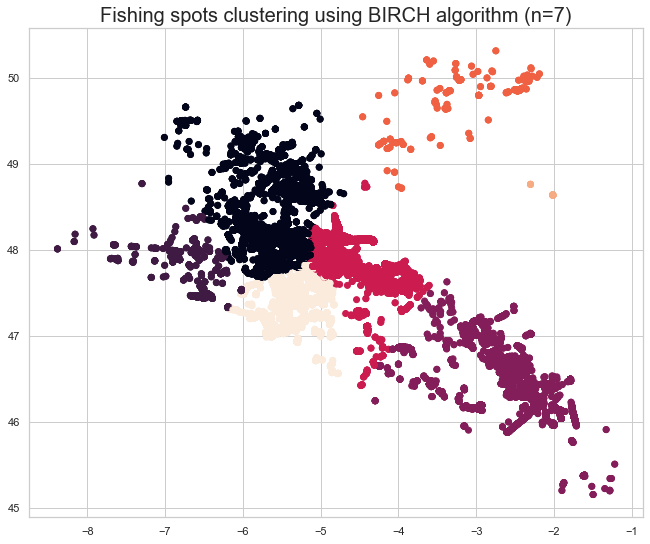

In [52]:
#Using BIRCH 

brc = Birch(n_clusters=7)
clusters = brc.fit_predict(fishing_coords)
print('Nof clusters:',len(np.unique(clusters)))
clusterd_fishing_coords=fishing_coords.copy()
clusterd_fishing_coords['clusters']=clusters
plt.figure(figsize=(11,9))
plt.title('Fishing spots clustering using BIRCH algorithm (n=7)',fontsize=20)
plt.scatter(clusterd_fishing_coords.lon,clusterd_fishing_coords.lat,c=clusterd_fishing_coords['clusters'])
plt.show()

# Illegal Fishing

## Camaret area, north

In [5]:
import datetime

#Camaret area, north
start=datetime.datetime(2015,2,5,0,0,0)
end=datetime.datetime(2016,1,21,0,0,0)

In [6]:
camaret=db.forbidden_fishing_areas.find({"id" : 'Camaret'})

In [7]:
camaret_violations=db.nari_dynamic.find({"navigationalstatus":{"$eq":7},
                                         "t":{"$gte":start,"$lte":end},
                                         "location":{"$geoWithin":{"$geometry":camaret[0]}}})

In [8]:
results3=[]
for i in camaret_violations:
    results3.append(i)

res3=pd.DataFrame(results3)
res3['sourcemmsi']=res3['sourcemmsi'].astype(str)

In [9]:
print('There are',len(res3['sourcemmsi'].unique()),'vessels that were fishing illegaly at Camaret area:')
print(res3['sourcemmsi'].unique())

There are 2 vessels that were fishing illegaly at Camaret area:
['228355800' '228853000']


## Concarneau area, south

In [10]:
start=datetime.datetime(2015,9,3,0,0,0)
end=datetime.datetime(2015,10,15,0,0,0)

import re
regx = re.compile("^Concarneau", re.IGNORECASE)

In [11]:
concarneau=db.forbidden_fishing_areas.find({"id" : regx})

In [12]:
concarneau_areas=list(concarneau)

In [13]:
concarenau_violations=[]

for area in concarneau_areas:
    violation = db.nari_dynamic.find({"navigationalstatus":{"$eq":7},
                                              "t":{"$gte":start,"$lte":end},
                                              "location":{"$geoWithin":{"$geometry":area}}})
    concarenau_violations.append(violation)

In [14]:
results4=[]
for violations in concarenau_violations:
    for j in violations:
        results4.append(j)

res4=pd.DataFrame(results4)
res4['sourcemmsi']=res4['sourcemmsi'].astype(str)

In [15]:
print('There are',len(res4['sourcemmsi'].unique()),'vessels that were fishing illegaly at Concarneau area:')
print(res4['sourcemmsi'].unique())

There are 2 vessels that were fishing illegaly at Concarneau area:
['228827000' '227577000']
